In [440]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os


# Daily Time Series

Source: Factset Fundamentals

## Stock Prices

In [441]:
data_dir = 'Data/Raw/Factset/STOCK/PRICES'
paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".xlsx")]

def load_dataframe(path, ticker):
    df = pd.read_excel(path, skiprows=2)
    df.dropna(inplace=True)
    df["Ticker"] = ticker
    return df

stock_prices = pd.concat([load_dataframe(x, x.split("/")[-1].split("-2018")[0].strip()) for x in paths])

output_path = 'Data/Processed/DAILY_STOCK_PRICES.xlsx'
stock_prices.to_excel(output_path, index=False)

stock_prices.sample(5)

,Date,Price,CVol,Change,% Change,% Return,Total Return (Gross),Cumulative Return %,Open,High,Low,Cumulative Change %,Ticker
1383,2023-07-07,9.60000,1185124.0,0.19000,2.019129,2.019139,11.221282,18.118758,9.60000,9.63000,9.45000,1.052632,DNO-NO
908,2021-08-19,7.68800,5419352.0,-0.40200,-4.969098,-4.969089,8.001100,-15.777895,7.84000,7.89000,7.61000,-19.073684,DNO-NO
44,2018-03-02,10.20500,5899097.0,-0.21500,-2.063340,-2.063340,10.205000,7.421053,10.30500,10.50000,10.14000,7.421053,DNO-NO
968,2021-10-27,203.81386,9888626.0,-0.61172,-0.299238,-0.299233,248.297900,-9.513242,203.21360,204.82968,202.08232,-25.724481,SHEL-GB
1446,2023-09-22,342.88376,16125290.0,-0.96804,-0.281528,-0.281527,451.060330,64.379107,341.63452,344.59323,339.54828,24.956514,SHEL-GB


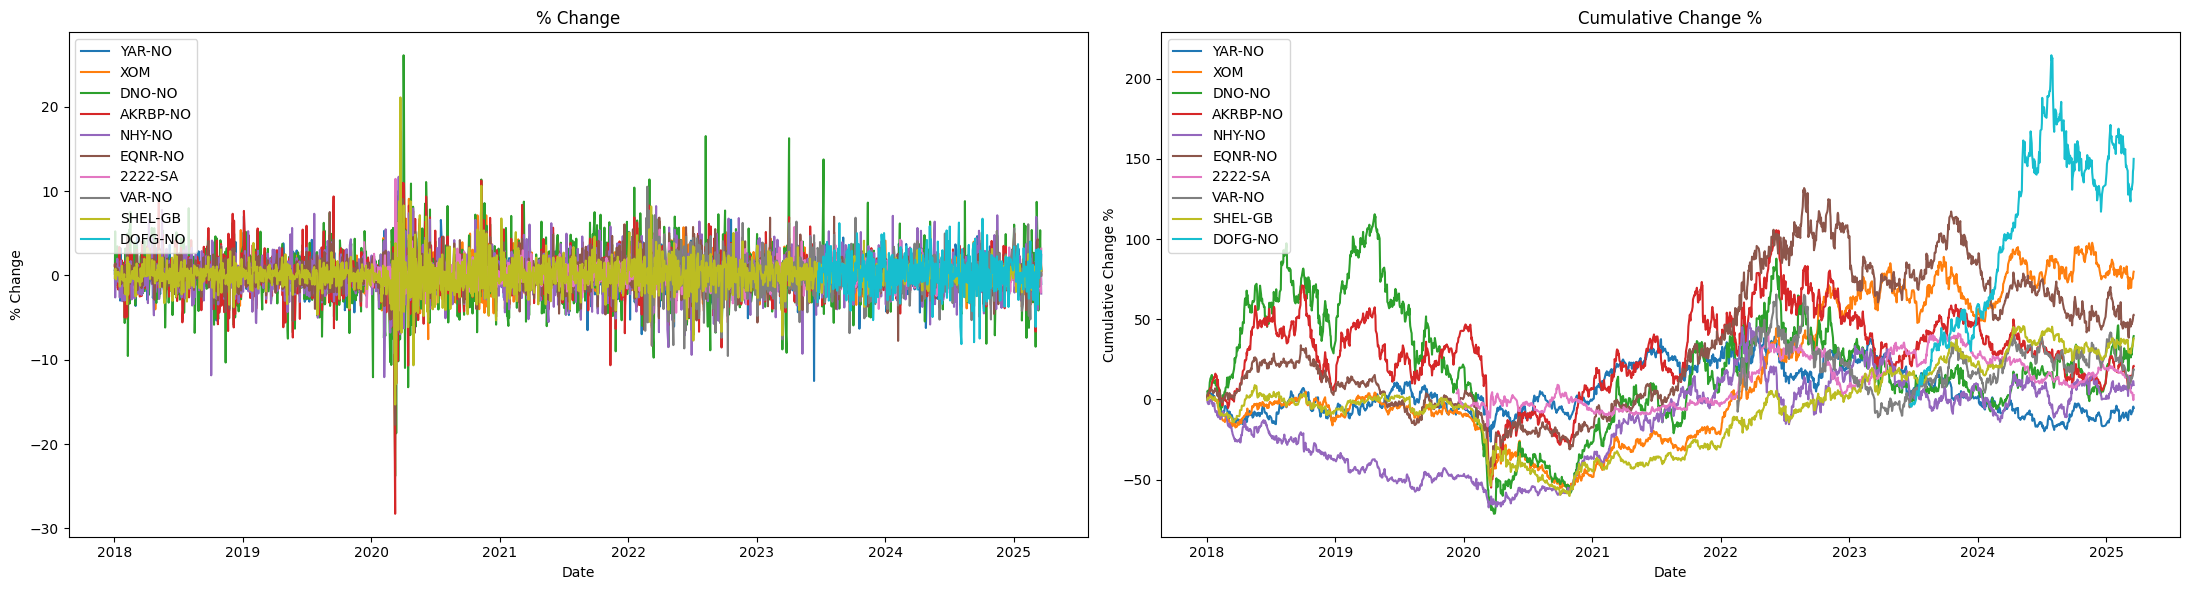

In [442]:
fig, axes = plt.subplots(1,2, figsize=(22,6))

plot_cols = ['% Change', 'Cumulative Change %']
plot_df = stock_prices[stock_prices.Ticker != 'KOG-NO'].copy() # Exclude Kongsberg Gruppen due to exceptional strock price increase

for i, col in enumerate(plot_cols):
    sns.lineplot(plot_df, x='Date', y=col, hue='Ticker', ax=axes[i])
    axes[i].set_title(col)    
    axes[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

### Feature Engineering
- Volume % Change: measure of activity
- Rolling Mean of % Returns: helps to detect momentum/trends over time. Dependent on window size
- Rolling Std of % Returns: measures risk by capturing volatility within the time window

In [443]:
features_stocks = stock_prices.sort_values(by=['Ticker', 'Date']).copy()
features_stocks['vol_pct_change'] = features_stocks['CVol'].pct_change()

windows = [5, 20]
for w in windows:
    features_stocks[f'pct_returns_mean_{w}'] =  features_stocks.groupby('Ticker')['% Change'].transform(lambda x: x.rolling(w).mean())
    features_stocks[f'pct_returns_std_{w}'] =  features_stocks.groupby('Ticker')['% Change'].transform(lambda x: x.rolling(w).std())

return_cols = ['Ticker', 'Date', '% Change']
col_idx = list(features_stocks.columns).index('vol_pct_change')
engineered_cols = list(features_stocks.columns[col_idx:])

features_stocks = features_stocks[return_cols + engineered_cols]
features_stocks.columns

features_stocks.rename(columns={'% Change': 'pct_return'}, inplace=True)   
features_stocks.dropna(inplace=True)
features_stocks.sample(5)

,Ticker,Date,pct_return,vol_pct_change,pct_returns_mean_5,pct_returns_std_5,pct_returns_mean_20,pct_returns_std_20
1798,DOFG-NO,2025-02-28,-0.562430,1.147591,-0.654633,1.621511,-0.367345,1.655232
1337,KOG-NO,2023-04-28,-0.375313,0.072712,0.565679,1.775215,0.614738,1.143370
1143,2222-SA,2022-08-03,0.062918,-0.540337,-0.143578,0.765663,0.066127,1.529858
680,DNO-NO,2020-09-21,-4.674022,-0.142318,-0.203054,3.278108,-0.748239,2.576733
1139,SHEL-GB,2022-07-05,-7.724375,0.753041,-1.373146,4.086121,-0.822564,2.749517


## Commodities

In [444]:
data_dir = 'Data/Raw/Factset/COMMODITIES'
paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".xlsx")]

commodities = pd.concat([load_dataframe(x, x.split("/")[-1].split("-PRICE")[0].strip()) for x in paths])

output_path = 'Data/Processed/DAILY_COMMODITY_PRICES.xlsx'
commodities.to_excel(output_path, index=False)

commodities.sample(5) 

,Date,Price,Change,% Change,Cumulative Change %,Ticker
534,2020-02-14,481.274930,5.336580,1.121275,-2.679058,WTI-FDS
1118,2022-06-09,1227.376600,6.468900,0.529843,124.873309,OILDB-FDS
907,2021-08-09,623.621770,-7.383830,-1.170169,14.256611,OILDB-FDS
875,2021-06-23,27.049240,-0.454920,-1.654004,10.233861,AECOCAD-FDS
85,2018-05-03,0.404248,-0.569408,-58.481484,-98.352569,AECOCAD-FDS


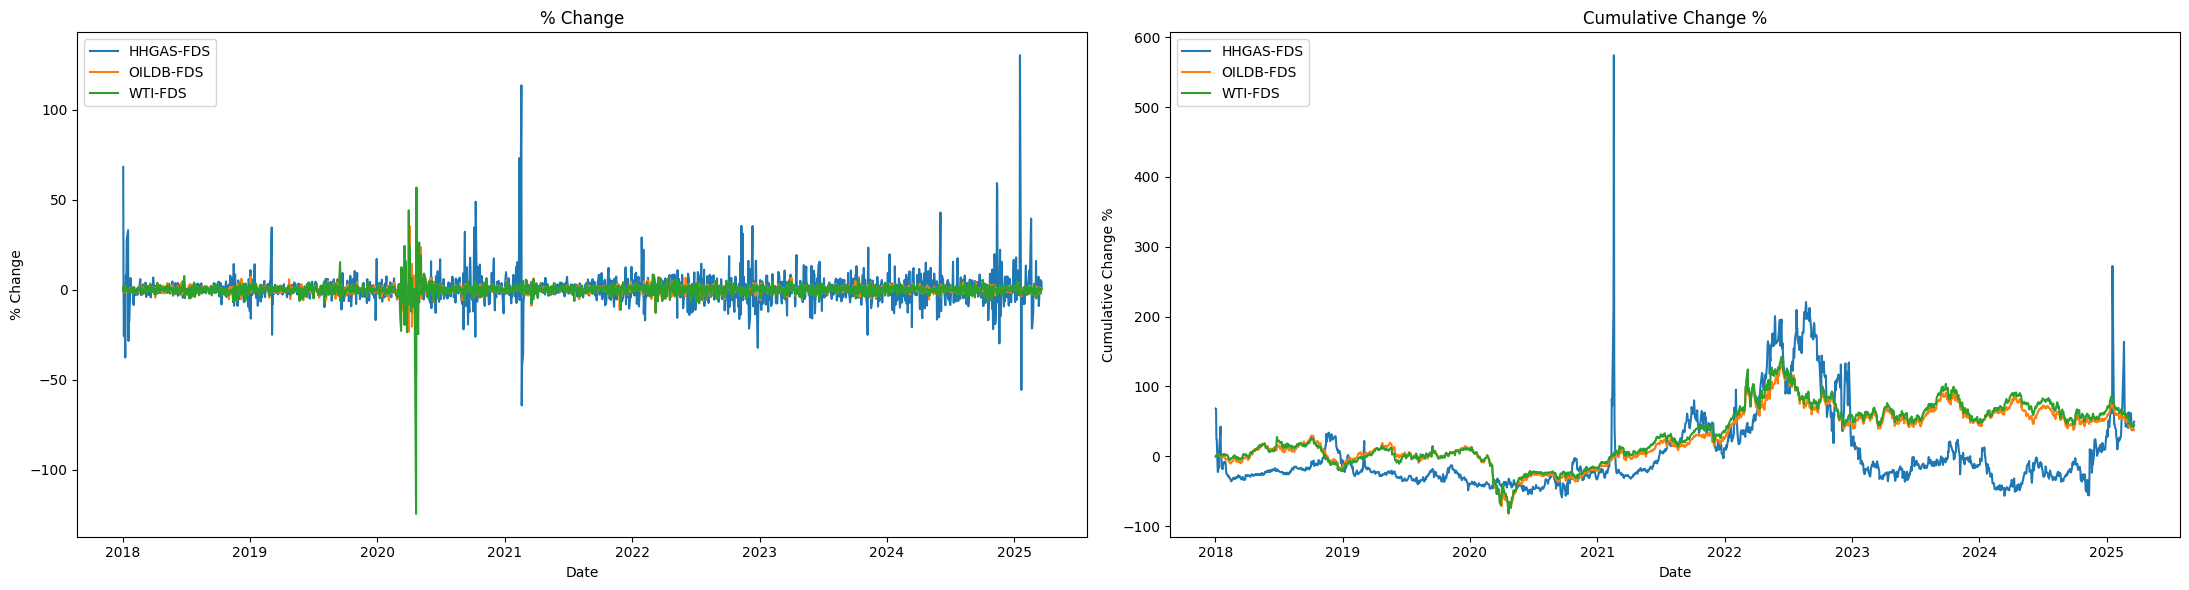

In [445]:
fig, axes = plt.subplots(1,2, figsize=(22,6))

plot_cols = ['% Change', 'Cumulative Change %']
plot_df = commodities[commodities.Ticker != 'AECOCAD-FDS'].copy() # Remove AECOCAD-FDS due to severe shocks causing scaling issues

for i, col in enumerate(plot_cols):
    sns.lineplot(plot_df, x='Date', y=col, hue='Ticker', ax=axes[i])
    axes[i].set_title(col)    
    axes[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

**Comment:** Limited value in including both OILDB-FDS and HHGAS-FDS. Can select either one or take the mean of the two.

## Currencies

In [446]:
data_dir = 'Data/Raw/Factset/CURRENCIES/SPOT'
paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".xlsx")]

currencies = pd.concat([load_dataframe(x, x.split("/")[-1].split("-HISTORY")[0].strip()) for x in paths])

output_path = 'Data/Processed/DAILY_EXCHANGE_RATES.xlsx'
currencies.to_excel(output_path, index=False)

currencies.sample(5) 

,Date,Bid,Ask,Mid,Change,% Change,Cumulative Change %,High,Low,Ticker
1515,2023-10-23,11.80550,11.808500,11.806983,0.105472,0.901354,20.208287,11.806983,11.806983,EURNOK
666,2020-07-21,10.49140,10.496200,10.493828,-0.085654,-0.809624,6.838901,10.493828,10.493828,EURNOK
879,2021-05-14,11.60830,11.618600,11.613442,-0.135057,-1.149568,4.960333,11.613442,11.613442,GBPNOK
952,2021-08-25,12.13020,12.142300,12.136175,0.018695,0.154281,9.684705,12.136175,12.136175,GBPNOK
1826,2024-12-31,12.52714,12.537358,12.532248,-0.016805,-0.133911,49.305076,12.532248,12.532248,CHFNOK


In [447]:
currencies_pivot = currencies.pivot(index="Date", columns="Ticker", values=["Cumulative Change %"]).reset_index()
currencies_pivot.columns = currencies_pivot.columns.get_level_values(1)
currencies_pivot.rename(columns={"": "Date"}, inplace=True)

# TODO: cumsum on mean daily returns is incorrect. Must either use compounding interest or direct mean of cumulative change % 
mean_df = currencies.groupby("Date").agg(daily_mean=pd.NamedAgg("% Change", "mean"), cumulative_mean=pd.NamedAgg("Cumulative Change %", "mean")).reset_index()
mean_df["Cumulative Mean"] = mean_df["daily_mean"].cumsum()
mean_df.rename(columns={'daily_mean': 'Mean % Change', 'Cumulative Mean': 'Mean Cumulative Change %'}, inplace=True)

In [448]:
mean_df.columns

Index(['Date', 'Mean % Change', 'cumulative_mean', 'Mean Cumulative Change %'], dtype='object')

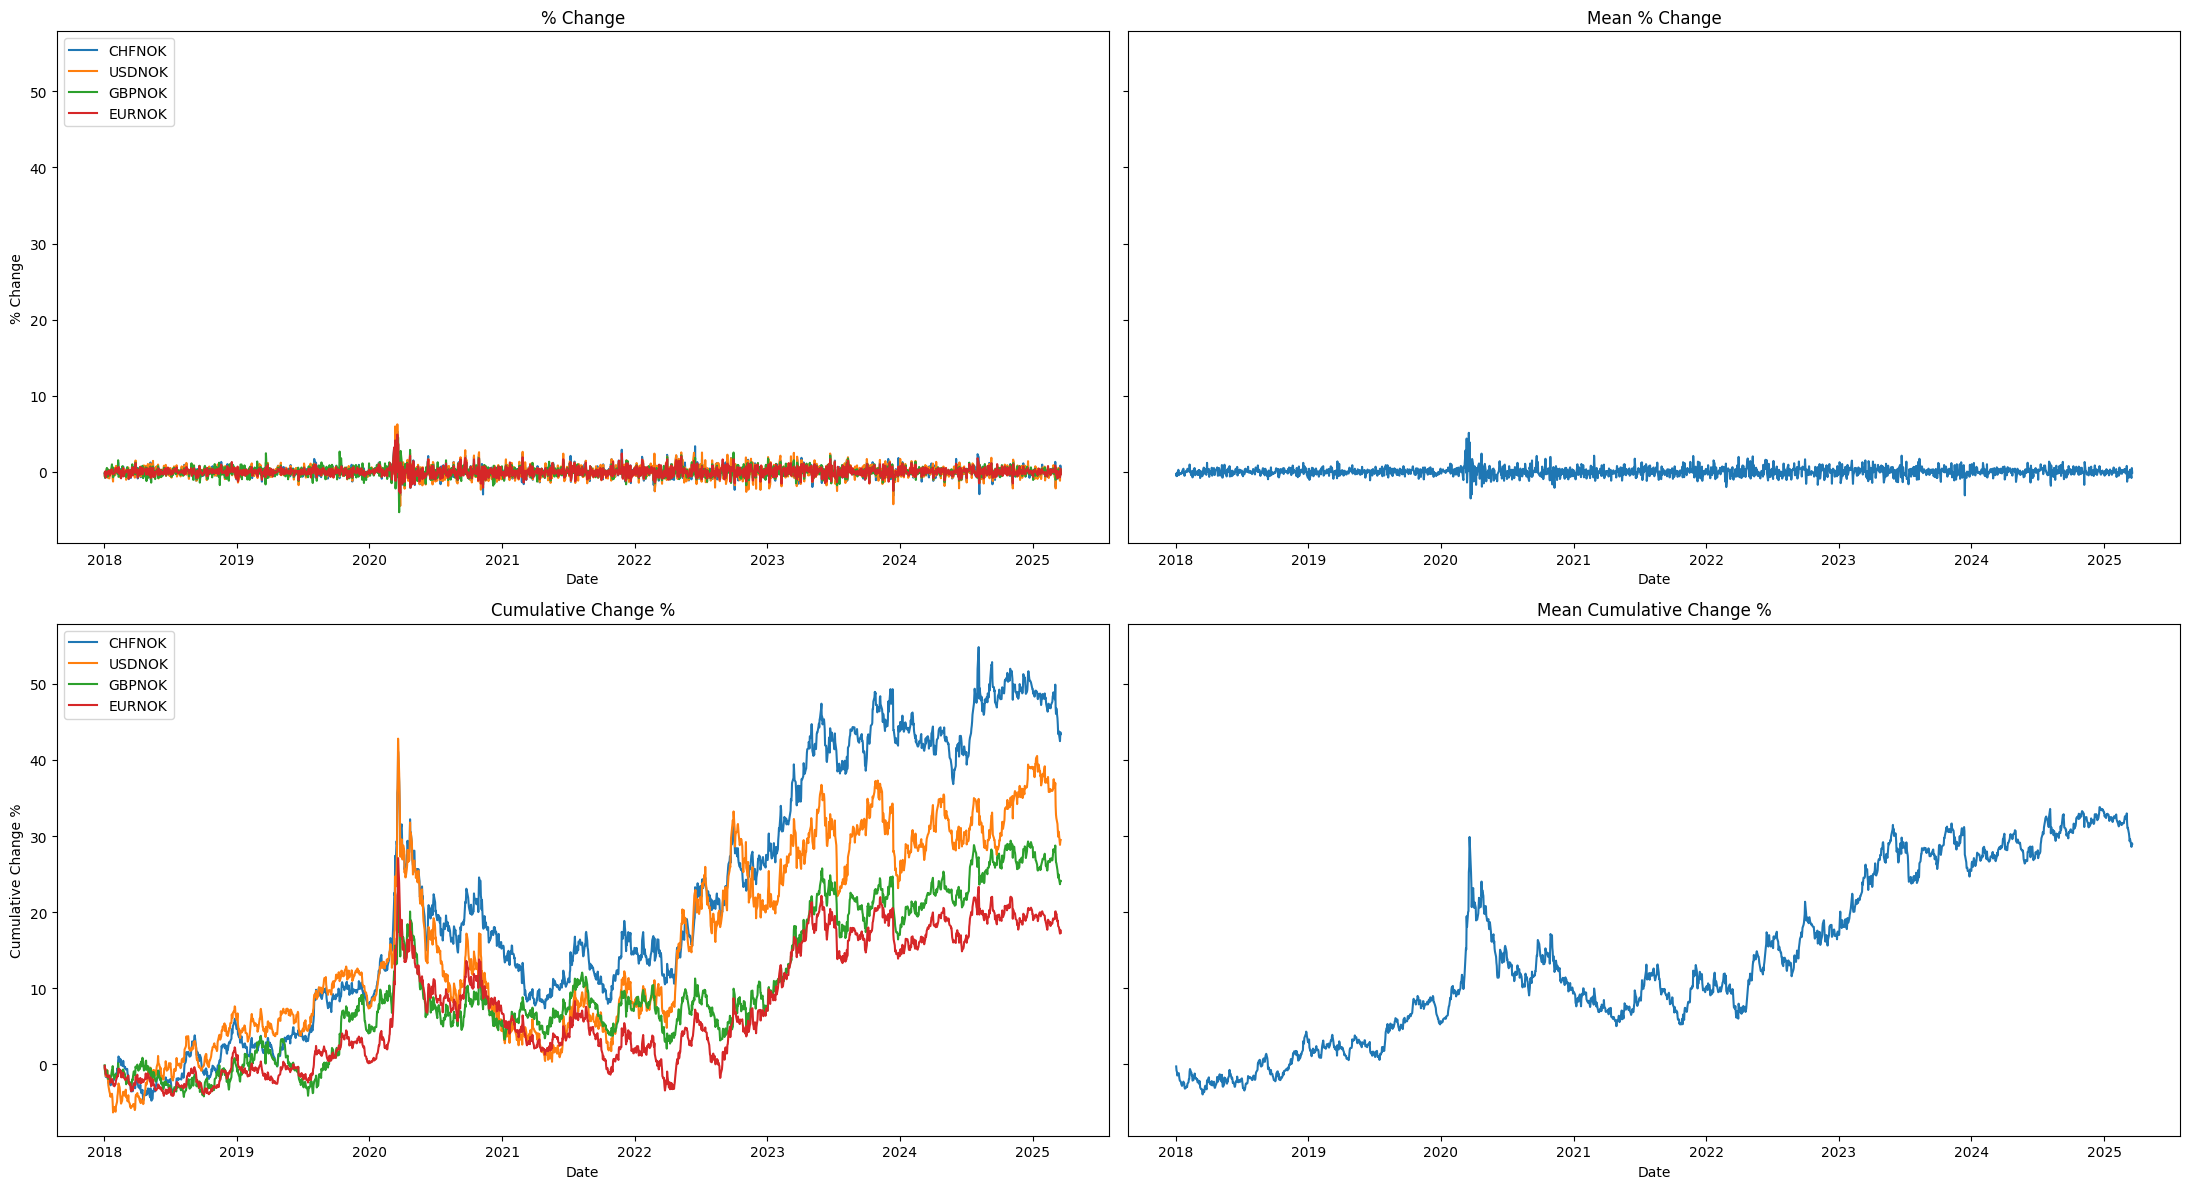

In [449]:
fig, axes = plt.subplots(2,2, figsize=(22,12), sharey=True)

plot_cols = ['% Change', 'Cumulative Change %']

for i, col in enumerate(plot_cols):
    sns.lineplot(currencies, x='Date', y=col, hue='Ticker', ax=axes[i,0])
    axes[i,0].set_title(col)    
    axes[i,0].legend(loc='upper left')

plot_cols = ['Mean % Change', 'Mean Cumulative Change %']
for i, col in enumerate(plot_cols):
    sns.lineplot(mean_df, x='Date', y=col, ax=axes[i,1])
    axes[i,1].set_title(col)    

plt.tight_layout()
plt.show()

## Daily Features

In [450]:
features_commodities = commodities[commodities.Ticker.isin(['WTI-FDS', 'HHGAS-FDS'])]\
        .pivot(index="Date", columns="Ticker", values=["% Change"])\
        .reset_index()

features_commodities.columns = features_commodities.columns.get_level_values(1)
features_commodities.rename(columns={"": "Date"}, inplace=True)
features_commodities.columns = ['Date'] + [f'com_{x}' for x in features_commodities.columns if x != 'Date']

features_currencies = currencies.pivot(index="Date", columns="Ticker", values=["% Change"]).reset_index()
features_currencies.columns = features_currencies.columns.get_level_values(1)
features_currencies.rename(columns={"": "Date"}, inplace=True)
features_currencies.columns = ['Date'] + [f'cur_{x}' for x in features_currencies.columns if x != 'Date']

comb_features = features_commodities.merge(features_currencies, how='inner', on='Date')
features_daily = features_stocks.merge(comb_features, how='inner', on='Date')

features_daily.columns = [x.lower() for x in features_daily.columns]

# Predict next day's return using today's features
features_daily['target_pct_return'] = features_daily.groupby('ticker')['pct_return'].shift(-1)
features_daily.dropna(inplace=True)
features_daily.drop(columns=['pct_return'], inplace=True)

features_daily.to_excel("Data/Processed/FEATURES_DAILY.xlsx", index=False)

features_daily.sample(5)

,ticker,date,vol_pct_change,pct_returns_mean_5,pct_returns_std_5,pct_returns_mean_20,pct_returns_std_20,com_hhgas-fds,com_wti-fds,cur_chfnok,cur_eurnok,cur_gbpnok,cur_usdnok,target_pct_return
7606,KOG-NO,2022-05-27,0.276916,0.813778,1.056726,-0.517016,4.734724,-10.265602,-1.695276,-0.254096,-0.712987,-0.323434,-0.643474,-2.906977
788,2222-SA,2024-02-08,0.398459,0.119352,1.239831,-0.196033,0.957235,-9.913439,3.701005,0.114060,0.483344,0.234596,0.441338,0.976999
7249,KOG-NO,2020-11-25,-0.461538,-0.063242,1.372104,1.141918,2.735179,-0.933885,0.993812,-0.688856,-0.700252,-0.755881,-0.933890,0.479616
4032,DNO-NO,2023-06-20,0.289669,-0.581192,0.245845,-0.047922,1.826027,14.058843,0.841169,0.743587,0.855830,0.578322,1.063989,-0.887574
13741,XOM,2023-01-13,-0.217874,0.180481,2.363939,0.380226,1.680610,-1.691176,1.461653,-0.265541,-0.333046,-0.057892,-0.544718,-0.396517


## Predict Daily Returns

In [451]:
# Test on EQNR-data
rf_regressor_df = features_daily[features_daily.ticker == 'EQNR-NO']\
        .sort_values('date')\
        .reset_index(drop=True)
        
split_ratio = 0.9
split_index = int(rf_regressor_df.shape[0] * split_ratio)

train_df = rf_regressor_df.iloc[:split_index]
test_df  = rf_regressor_df.iloc[split_index:]

### Baseline (Stock Features Only)

In [452]:
from sklearn.preprocessing import StandardScaler

key = [x for x in rf_regressor_df.columns if x.startswith('com')][0]
idx = list(rf_regressor_df.columns).index(key)
ignore_cols = ['ticker', 'date', 'target_pct_return'] + list(rf_regressor_df.columns[idx:])

feature_cols = [x for x in rf_regressor_df.columns if x not in ignore_cols]
target_col = 'target_pct_return'

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

y_train = train_df[target_col].values
y_test = test_df[target_col].values

In [453]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)
model = rf.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

MSE: 3.7014972259896175
R2 -0.07472418535048453


**Comment:** daily stock returns are dominated by random movements, resulting in a low signal-to-noise ratio. Consequently, it becomes difficult for any model to predict next-day return. Instead, we might consider trying to predict returns over 5-10 days,

### Stock Features, Commodities & Exchange Rates 

In [454]:
from sklearn.preprocessing import StandardScaler

ignore_cols = ['ticker', 'date', 'target_pct_return']
feature_cols = [x for x in rf_regressor_df.columns if x not in ignore_cols]
target_col = 'target_pct_return'

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
X_test = scaler.transform(test_df[feature_cols])

y_train = train_df[target_col].values
y_test = test_df[target_col].values

In [455]:
X_train.shape

(1557, 11)

In [456]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)
model = rf.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2", r2_score(y_test, y_pred))

MSE: 3.6980179713761907
R2 -0.07371398897541037


# Financials

In [457]:
map_quarter = {'MAR': 'Q1', 'JUN': 'Q2', 'SEP': 'Q3', 'DEC':'Q4'}
quarter_end_month_day = {'Q1': '-03-31','Q2': '-06-30','Q3': '-09-30','Q4': '-12-31'}

In [458]:
def load_financials(file_path: str, first_account: str) -> pd.DataFrame:
    df = pd.read_excel(file_path)

    company_name, symbol = str(df.columns[0]).replace(")", "").split(" (")

    quarter_year = [x.split(" '") for x in df.iloc[6].tolist() if pd.notna(x)]
    quarter = [map_quarter.get(x[0], None) for x in quarter_year]
    year = [int("20" + x[1]) for x in quarter_year]

    tmp_columns = [f"{q} {y}" for q,y in zip(quarter, year)]

    df.columns = [''] + tmp_columns
    
    ub = df.shape[0]
    
    i = 4
    while i < ub:
        if df.iloc[i, 0] == first_account:
            break
        i += 1
    
    df = df.iloc[i:-1].reset_index(drop=True)

    df.dropna(how= 'all', inplace=True)
    
    out_df = df.T.copy()
    out_df.columns = out_df.iloc[0]
    out_df = out_df.iloc[1:]
    
    out_df["Company Name"] = company_name
    out_df["Ticker"] = symbol
    
    out_df = out_df.reset_index(names="QuarterYear")
    out_df["Quarter"] = out_df.QuarterYear.apply(lambda x: x.split(" ")[0])
    out_df["Year"] = out_df.QuarterYear.apply(lambda x: int(x.split(" ")[1].strip()))
    out_df["EoQ Date"] = out_df.apply(lambda row: pd.to_datetime(f"{row['Year']}{quarter_end_month_day[row['Quarter']]}"), axis=1)
    
    return out_df.dropna(how='all', axis=1).copy()

## Income Statement

In [459]:
data_dir = 'Data/Raw/Factset/COMPANY FINANCIALS/INCOME-STATEMENT'
paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".xlsx")]

In [460]:
def load_income_statement(file_path: str) -> pd.DataFrame:
    income_stmt = load_financials(file_path, 'Sales')
    
    dim_cols = ['Ticker', 'EoQ Date']
    relevant_cols = ['Sales', 'Gross Income', 'EBITDA', 'EBIT', 'Net Income', 'EPS (diluted)', 'Dividends per Share']
    # other_cols = ['Earnings Persistence']
    
    income_stmt = income_stmt[dim_cols + relevant_cols]
    
    for col in relevant_cols:
        income_stmt[col] = income_stmt[col].pct_change()
    
    income_stmt.sort_values(['Ticker', 'EoQ Date'], inplace=True)
    
    return income_stmt.dropna()
    
income_stmt = pd.concat([load_income_statement(x) for x in paths])

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_7884/1009832235.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  income_stmt[col] = income_stmt[col].pct_change()
/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_7884/1009832235.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  income_stmt[col] = income_stmt[col].pct_change()


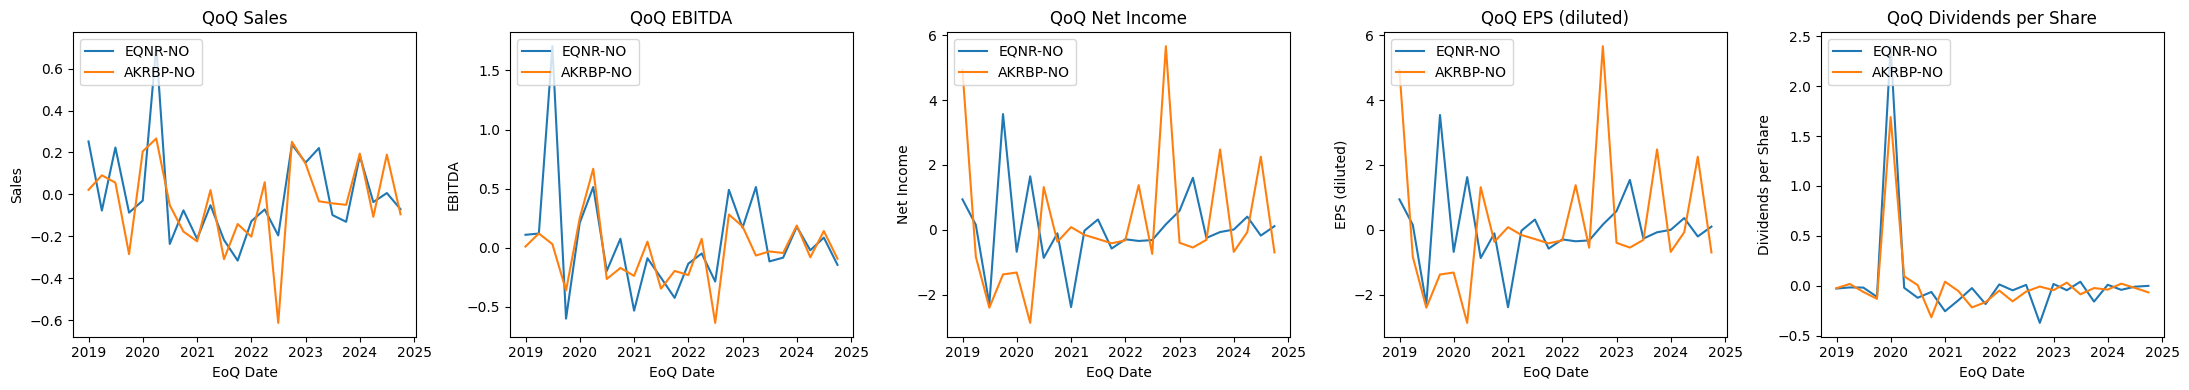

In [461]:
fig, axes = plt.subplots(1,5, figsize=(22,4))

plot_cols = ['Sales', 'EBITDA', 'Net Income', 'EPS (diluted)', 'Dividends per Share']

for i, col in enumerate(plot_cols):
    sns.lineplot(income_stmt, x='EoQ Date', y=col, hue='Ticker', ax=axes[i])
    axes[i].set_title(f'QoQ {col}')
    axes[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

## Balance Sheet

In [462]:
data_dir = 'Data/Raw/Factset/COMPANY FINANCIALS/BALANCE-SHEET'
paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".xlsx")]

In [463]:
def load_balance_sheet(file_path: str) -> pd.DataFrame:
    df = load_financials(file_path, 'Assets')

    dim_cols = ['Ticker', 'EoQ Date']
    
    df['Current Ratio'] = df['Total Current Assets'] / df['Total Current Liabilities']
    
    df['Quick Ratio'] = (
        df['Cash & Short-Term Investments'] + 
        df['Accounts Receivables, Net']
    ) / df['Total Current Liabilities']
    
    df['Debt/Equity'] = df['Total Liabilities'] / df['Total Equity']
    
    df['Net Debt/Equity'] = (
        df['Long-Term Debt'] +
        df['ST Debt & Curr. Portion LT Debt'] -
        df['Cash & Short-Term Investments']
    ) / df['Total Liabilities']
    
    relevant_cols = ['Current Ratio', 'Quick Ratio', 'Debt/Equity', 'Net Debt/Equity', 'Book Value per Share']
    
    for col in relevant_cols:
        df[col] = df[col].pct_change()
    
    return df[dim_cols + relevant_cols].dropna()

balance_sheet = pd.concat([load_balance_sheet(x) for x in paths])

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_7884/2270522921.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].pct_change()
/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_7884/2270522921.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].pct_change()


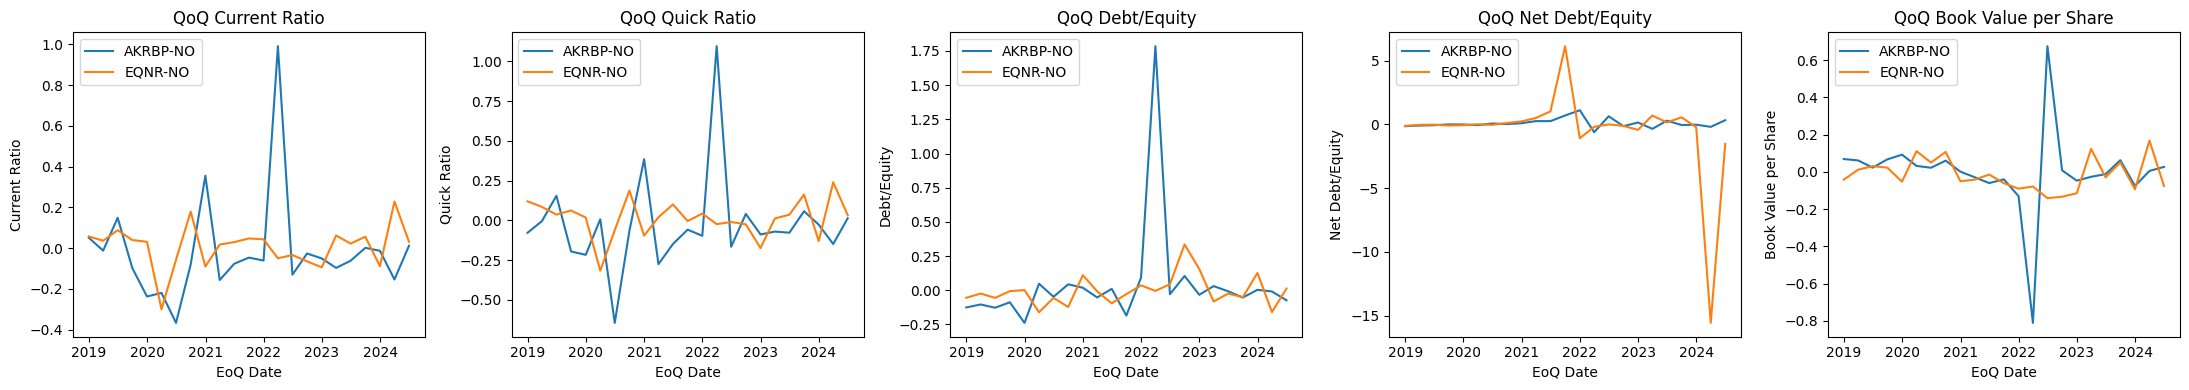

In [464]:
fig, axes = plt.subplots(1,5, figsize=(22,4))

plot_cols = ['Current Ratio', 'Quick Ratio', 'Debt/Equity', 'Net Debt/Equity', 'Book Value per Share']

for i, col in enumerate(plot_cols):
    sns.lineplot(balance_sheet, x='EoQ Date', y=col, hue='Ticker', ax=axes[i])
    axes[i].set_title(f'QoQ {col}')
    axes[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

## Cash Flows

In [465]:
data_dir = 'Data/Raw/Factset/COMPANY FINANCIALS/CASH-FLOW'
paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".xlsx")]

In [466]:
def load_cash_flows(file_path: str) -> pd.DataFrame:
    df = load_financials(file_path, 'Operating Activities')
    
    dim_cols = ['Ticker', 'EoQ Date']
    relevant_cols = ['Free Cash Flow', 'Cash Dividends Paid']
    
    for col in relevant_cols:
        df[col] = df[col].pct_change()
        
    return df[dim_cols + relevant_cols].dropna()

cash_flows = pd.concat([load_cash_flows(x) for x in paths])

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_7884/3901917224.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].pct_change()
/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_7884/3901917224.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].pct_change()


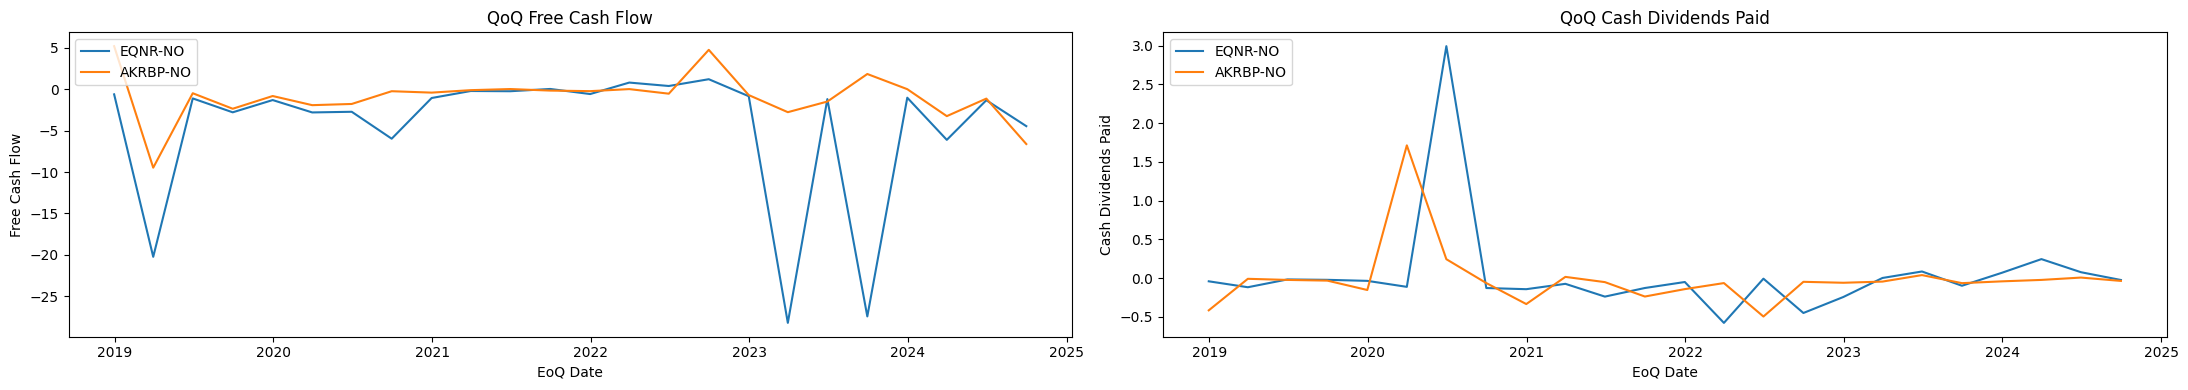

In [467]:
fig, axes = plt.subplots(1,2, figsize=(22,4))

plot_cols = ['Free Cash Flow', 'Cash Dividends Paid'] 

for i, col in enumerate(plot_cols):
    sns.lineplot(cash_flows, x='EoQ Date', y=col, hue='Ticker', ax=axes[i])
    axes[i].set_title(f'QoQ {col}')
    axes[i].legend(loc='upper left')
    
plt.tight_layout()
plt.show()

## Key Items

In [468]:
data_dir = 'Data/Raw/Factset/COMPANY FINANCIALS/KEY-ITEMS'
paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x.endswith(".xlsx")]

## Quarterly Features

In [469]:
dim_cols = ['Ticker', 'EoQ Date']
features_quarterly = income_stmt\
    .merge(balance_sheet, how='inner', on=dim_cols)\
    .merge(cash_flows, how='inner', on=dim_cols)
    
features_quarterly.columns = [x.lower().replace(' ', '_') for x in dim_cols]\
    + [f'qr_fin_{x.lower().replace(" ", "_")}' for x in features_quarterly.columns if x not in dim_cols]

features_daily.to_excel("Data/Processed/FEATURES_QUARTERLY.xlsx", index=False)
features_quarterly.sample(5)

,ticker,eoq_date,qr_fin_sales,qr_fin_gross_income,qr_fin_ebitda,qr_fin_ebit,qr_fin_net_income,qr_fin_eps_(diluted),qr_fin_dividends_per_share,qr_fin_current_ratio,qr_fin_quick_ratio,qr_fin_debt/equity,qr_fin_net_debt/equity,qr_fin_book_value_per_share,qr_fin_free_cash_flow,qr_fin_cash_dividends_paid
37,AKRBP-NO,2022-06-30,-0.612059,-0.649910,-0.636543,-0.643808,-0.745238,-0.552889,-0.058357,-0.130694,-0.166347,-0.028832,0.635244,0.675165,-0.529194,-0.494545
0,EQNR-NO,2018-12-31,0.252699,0.093301,0.109029,0.075887,0.936594,0.937740,-0.028121,0.056961,0.118812,-0.054870,-0.118719,-0.041925,-0.609314,-0.040234
12,EQNR-NO,2021-12-31,-0.127450,-0.148766,-0.135226,-0.147533,-0.294200,-0.296805,0.012966,0.042986,0.042436,0.035779,-1.088958,-0.090013,-0.572522,-0.049283
13,EQNR-NO,2022-03-31,-0.071375,-0.159999,-0.049051,-0.164834,-0.346918,-0.354989,-0.045892,-0.050138,-0.024249,-0.004393,-0.194401,-0.078347,0.813403,-0.576644
5,EQNR-NO,2020-03-31,0.706680,3.679060,0.513388,7.882831,1.647710,1.624694,-0.020441,-0.300256,-0.316973,-0.160941,0.003927,0.111160,-2.794918,-0.111616


# Combine Features

In [482]:
features_combined = pd.merge_asof(
    features_daily.sort_values('date'),
    features_quarterly.sort_values('eoq_date'),
    left_on='date',
    right_on='eoq_date',
    direction='backward',  # ensures we only look backwards in time (i.e., lag)
    by='ticker' # handle deep-format with multiple companies
)

features_combined = features_combined[features_combined.ticker.isin(features_quarterly.ticker.unique())]
features_combined.dropna(inplace=True)

features_combined.to_excel("Data/Processed/FEATURES_COMBINED.xlsx", index=False)
features_combined.sample(10)

,ticker,date,vol_pct_change,pct_returns_mean_5,pct_returns_std_5,pct_returns_mean_20,pct_returns_std_20,com_hhgas-fds,com_wti-fds,cur_chfnok,...,qr_fin_net_income,qr_fin_eps_(diluted),qr_fin_dividends_per_share,qr_fin_current_ratio,qr_fin_quick_ratio,qr_fin_debt/equity,qr_fin_net_debt/equity,qr_fin_book_value_per_share,qr_fin_free_cash_flow,qr_fin_cash_dividends_paid
2938,EQNR-NO,2019-08-08,-0.324928,-0.857707,0.947174,-0.725381,1.482038,-2.534865,2.600910,-0.680662,...,-2.300423,-2.299956,-0.018230,0.087925,0.035657,-0.055588,-0.023387,0.030651,-1.101399,-0.016174
6767,EQNR-NO,2021-06-10,0.783298,-0.098809,0.713967,0.273836,1.543002,0.096070,0.726130,0.084893,...,-0.028909,-0.028620,-0.145389,0.017026,0.019161,-0.008038,0.502065,-0.041735,-0.205529,-0.072694
4944,EQNR-NO,2020-07-31,0.280823,-1.444713,1.463777,-0.104498,1.669257,0.313851,-0.160024,-0.547980,...,-0.869142,-0.870273,-0.120560,-0.057396,-0.061962,-0.055904,-0.037192,0.050128,-2.715361,2.993388
2329,EQNR-NO,2019-04-12,0.610178,0.480369,1.301593,0.122316,1.068470,0.747104,0.039669,-0.192701,...,0.149997,0.150791,-0.016968,0.036154,0.084436,-0.024031,-0.039196,0.011941,-20.240171,-0.116697
10323,EQNR-NO,2022-12-28,-0.018778,-0.263707,1.120504,-0.249953,1.316181,-16.153322,0.070889,0.819224,...,0.165675,0.159769,-0.372284,-0.065416,-0.025313,0.334810,-0.122413,-0.133398,1.219173,-0.448919
8201,AKRBP-NO,2022-02-03,-0.454984,-1.214643,1.499921,0.186739,2.843248,-13.327922,1.702512,-0.521274,...,-0.327882,-0.327880,-0.048523,-0.061146,-0.097708,0.093183,1.106266,-0.130276,-0.222841,-0.141011
2450,AKRBP-NO,2019-05-08,-0.232248,-2.138945,2.548419,-0.919034,2.369338,4.128389,1.358730,0.567895,...,-0.834521,-0.834543,0.017880,-0.012538,-0.005605,-0.103608,-0.094344,0.061475,-9.468897,-0.008014
5228,EQNR-NO,2020-09-17,0.113376,0.519257,1.341714,0.085548,1.737962,-19.301134,2.807968,0.507797,...,-0.869142,-0.870273,-0.120560,-0.057396,-0.061962,-0.055904,-0.037192,0.050128,-2.715361,2.993388
7442,EQNR-NO,2021-09-30,0.858664,1.552187,1.605936,0.748170,1.807267,-2.728677,0.099076,-0.060310,...,-0.580982,-0.581754,-0.183657,0.047234,-0.005022,-0.027731,6.129004,-0.060840,0.041955,-0.126654
14237,EQNR-NO,2024-07-18,0.006818,0.628774,1.044080,0.073180,1.057768,1.151520,0.151914,0.389188,...,-0.180956,-0.206060,-0.009646,0.030944,0.031852,0.012418,-1.534810,-0.075712,-1.318855,0.077224
